In [1]:
from KGS import * # Utilizing my own package for data analysis. Remember to also send enviroment when sharing. 
import scipp as sc
from IPython.display import Image
from TubeMeasurment_mccode import BIFROST_measurement
mpl.rcParams['font.size']        = 20

In [2]:
#BIFROST_measurement.load_scan('Phonon_Pb_v2_','Pb_phonon_Data_1t_Cluster_corrected',set_Elim=(-0.5,7), Correct=True)

## Load the information

In [3]:
settings = np.loadtxt('Pb_phonon_Data_1t_Cluster_corrected').T

## Organize into scipp array

In [4]:

qx = sc.array(dims=["row"], values=settings[3], unit="Å^(-1)")
qy = sc.array(dims=["row"], values=settings[4], unit="Å^(-1)")
deltaE = sc.array(dims=["row"], values=settings[2], unit="meV")
Q = sc.array(dims=["row"], values=np.sqrt(settings[3]**2+settings[4]**2), unit="Å^(-1)")

recording = sc.DataArray(
    data=sc.array(dims=["row"], values=settings[0], unit="arb. units", variances=settings[1]**2),  #, variances=settings[1]
    coords={"qx": qx, "qy": qy, "deltaE":deltaE, "Q":Q}
)
recording

<scipp.DataArray>
Dimensions: Sizes[row:250093494, ]
Coordinates:
* Q                         float64           [1/Å]  (row)  [2.18739, 2.18286, ..., 2.82606, 2.82401]
* deltaE                    float64            [meV]  (row)  [6.9966, 6.93829, ..., -0.481506, -0.495033]
* qx                        float64           [1/Å]  (row)  [0.315751, 0.311437, ..., -1.12131, -1.12125]
* qy                        float64           [1/Å]  (row)  [2.16448, 2.16053, ..., 2.59408, 2.59187]
Data:
                            float64      [arb. unit]  (row)  [0, 0, ..., 0, 0]  [0, 0, ..., 0, 0]

In [28]:
sc.show(recording)

In [5]:
qx_bins = round((max(recording.coords['qx'].values) - min(recording.coords['qx'].values))/0.02)
qy_bins = round((max(recording.coords['qy'].values) - min(recording.coords['qy'].values))/0.02)
E_bins = round((max(recording.coords['deltaE'].values) - min(recording.coords['deltaE'].values))/0.1)

print(qx_bins, qy_bins, E_bins)
print(max(recording.coords['qx'].values))

273 170 75
3.51465


## Perform the rebinning

In [6]:
import scipp as sc


da = recording.bin(qx=qx_bins, qy=qy_bins, deltaE=E_bins)
sliced = da.bins.mean()
#sliced.values[(da.bins.size() == sc.index(0)).values] = np.nan
sliced.save_hdf5(filename='Pb_phonon_rebinned.hdf5')

sc.show(da)

/Users/kristinekrighaar/opt/anaconda3/lib/python3.9/site-packages/scipp/core/deprecation.py:7: VisibleDeprecationWarning: sc.DataArray.attrs has been deprecated and will be removed in Scipp v24.12.0. The deprecation includes sc.DataArray.meta and sc.DataArray.drop_attrs. For unaligned coords, use sc.DataArray.coords and unset the alignment flag. For other attributes, use a higher-level data structure.
  warnings.warn(


In [7]:
#np.savetxt('Phonon_Pb_rebinned_1', matrix, delimiter='\t', fmt='%f') # pip install pythreejs

In [8]:
#slicedQ = recording.bin(deltaE=150, Q=200)

In [9]:
#slicedQ = slicedQ.bins.mean()
#slicedQ

In [10]:
E_min = -2 * sc.Unit('meV')
E_max = 10 * sc.Unit('meV')

Q_min = 0 * sc.Unit('Å^(-1)')
Q_max = 4.5 * sc.Unit('Å^(-1)')

#fig, ax = plt.subplots(1, 1, figsize=(6, 4))

#p5 = slicedQ['Q',Q_min:Q_max]['deltaE', E_min:E_max].plot(ax=ax, cmap='jet')

#ax.set_ylabel(r'$\Delta E$ [meV]')
#ax.set_xlabel(r'$|Q|$ [Å$^{-1}$]')

In [11]:
#E_layer = 2 * sc.Unit('meV')

import matplotlib.colors as colors

qx_min = 0 * sc.Unit('Å^(-1)')
qx_max = 2 * sc.Unit('Å^(-1)')

qy_min = -2 * sc.Unit('Å^(-1)')
qy_max = 4.0 * sc.Unit('Å^(-1)')


import ipywidgets as ipw
import plopp.widgets as pw
import plopp as pp
import mpld3



def update_plot(amp):
    E_layer = amp * sc.Unit('meV')
    plt.figure(figsize=(6,4))
    p1 = sliced['deltaE', E_layer]['qy', qy_min:qy_max].transpose()#.plot(cmap='jet')
    im = plt.pcolormesh(p1.coords['qx'].values, p1.coords['qy'].values, p1.values, cmap='jet',  vmin=0, vmax=0.0001) # vmin=0, vmax=3e-5
    cbar = plt.colorbar(im)
    cbar.set_label('I [a.u.]')
    plt.xlim(-2,2)
    plt.ylim(0,4)
    plt.xlabel('$q_x$ [1/Å]')
    plt.ylabel('$q_y$ [1/Å]')
    plt.title(f"$\Delta E =$ {amp:.2f} meV")
    plt.savefig('Pb_phonon_BIFROST_qxqy_mid.pdf', format='pdf', bbox_inches='tight')
    

w = ipw.FloatSlider( 
    value=3.44,
    min=min(sliced.coords['deltaE'].values),
    max=7.0,
    step=(sliced.coords['deltaE'].values[1]-sliced.coords['deltaE'].values[0]),
    description="Delta_E:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
)
# Display the slider

ipw.interactive(update_plot, amp=w)



interactive(children=(FloatSlider(value=3.44, description='Delta_E:', max=7.0, min=-0.499815, step=0.099995586…

In [12]:
# da = recording.bin(qx=120, qy=120, deltaE=40)
# sliced = da.bins.sum()
# sliced.values[(da.bins.size() == sc.index(0)).values] = np.nan

qxE = recording.bin(qx=qx_bins, qy=qy_bins, deltaE=E_bins)
sliced_qxE = qxE.bins.mean()
#sliced_qxE.values[(qxE.bins.size() == sc.index(0)).values] = np.nan

# Sliced along $q_x$

In [13]:

qx_min = -1 * sc.Unit('Å^(-1)')
qx_max = 2 * sc.Unit('Å^(-1)')

E_min = -0.05 * sc.Unit('meV')
E_max = 7.0 * sc.Unit('meV')


def update_plot_qxE(amp):
    qy_layer = amp * sc.Unit('Å^(-1)')
    plt.figure(figsize=(6,4))
    p1 = sliced_qxE['qy', qy_layer]['deltaE', E_min:E_max].transpose()#.plot(cmap='jet')
    im = plt.pcolormesh(p1.coords['qx'].values, p1.coords['deltaE'].values, p1.values, cmap='jet', vmin=0, vmax=0.0001) # norm=colors.LogNorm()
    cbar = plt.colorbar(im)
    cbar.set_label('I [a.u.]')
    plt.xlim(-2,2.5)
    plt.ylim(0,7)
    plt.xlabel('$q_x$ [1/Å]')
    plt.ylabel('$\Delta E$ [meV]')
    plt.title(f"$q_y =$ {amp:.2f} Å$^{-1}$")
    plt.savefig('Pb_phonon_BIFROST_qxE_high.pdf', format='pdf', bbox_inches='tight')
    

w_qxE = ipw.FloatSlider( 
    value=2.73,
    min=min(sliced_qxE.coords['qy'].values),
    max=4,
    step=(sliced_qxE.coords['qy'].values[1]-sliced_qxE.coords['qy'].values[0]),
    description="q_y:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
)
# Display the slider



ipw.interactive(update_plot_qxE, amp=w_qxE)


interactive(children=(FloatSlider(value=2.73, description='q_y:', max=4.0, min=0.409985, step=0.01998728823529…

## Cut integrating energy - x-axis $q_x$

In [14]:
mpl.rcParams['font.size']        = 15

c1_qy_min = 2.53 * sc.Unit('Å^(-1)')

c1_Emin = 1.8 * sc.Unit('meV')
c1_Emax = 2.2 * sc.Unit('meV')

c1_qxmin = -0.5 * sc.Unit('Å^(-1)')
c1_qxmax = 0.5 * sc.Unit('Å^(-1)')


c1 = sliced_qxE['qy', c1_qy_min]['qx',c1_qxmin:c1_qxmax]['deltaE', c1_Emin:c1_Emax]
c1 = sc.sum(c1, dim='deltaE')

qx_c1 = c1.coords['qx'].values
qx_c1 = (qx_c1[:-1] + qx_c1[1:]) / 2.0

E_c1_guess = {'A1':0.0002, 'mu1':-0.2, 'sigma1': 0.01,
                 'A2': 0.0002, 'mu2':0.2, 'sigma2': 0.01,}
E_c1_limit = {'A2': (0.0001,0.0003), 'mu2':(0.1,0.3)}

Ecut_fit1 = fit(qx_c1, c1.values, np.sqrt(c1.variances), gaussN, E_c1_guess, limits=E_c1_limit)

Ecut_fit1.hesse()


Given names not corresponding to function, overwriting...


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 482.6                      │              Nfcn = 537              │
│ EDM = 0.000343 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │ 227.5e-6  │  1.5e-6   │            │            │         │         │       │
│ 1 │ mu1    │-191.31e-3 │  0.13e-3  │            │            │         │         │       │
│ 2 │ sigma1 │ 23.10e-3  │  0.07e-3  │            │            │         │         │       │
│ 3 │ A2     │ 0.226e-3  │ 0.010e-3  │            │            │ 0.0001  │ 0.0003  │       │
│ 4 │ mu2    │ 191.1e-3  │  0.5e-3   │            │            │   0.1   │   0.3   │       │
│ 5 │ sigma2 │ 16.70e-3  │  0.19e-3  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────┐
│        │        A1       mu1    sigma1        A2       mu2    sigma2 │
├────────┼─────────────────────────────────────────────────────────────┤
│     A1 │  2.36e-12     6e-12 -4.99e-11 -1.62e-21  3.94e-19   9.8e-20 │
│    mu1 │     6e-12  1.69e-08 -2.62e-10 -1.71e-19 -3.85e-18  7.17e-18 │
│ sigma1 │ -4.99e-11 -2.62e-10  4.55e-09   1.1e-19  -6.1e-18 -5.22e-18 │
│     A2 │ -1.62e-21 -1.71e-19   1.1e-19  1.08e-10  1.05e-09 -8.49e-10 │
│    mu2 │  3.94e-19 -3.85e-18  -6.1e-18  1.05e-09  3.01e-07 -2.48e-08 │
│ sigma2 │   9.8e-20  7.17e-18 -5.22e-18 -8.49e-10 -2.48e-08  3.53e-08 │
└────────┴─────────────────────────────────────────────────────────────┘

## Cuts integrating qx - x-axis energy

In [15]:
c2_qy_min = 2.53 * sc.Unit('Å^(-1)')

c2_Emin = 1.0 * sc.Unit('meV')
c2_Emax = 3.0 * sc.Unit('meV')

c2_qxmin = 0.2 * sc.Unit('Å^(-1)')
#c2_qxmax = 0.23 * sc.Unit('Å^(-1)')


c2 = sliced_qxE['qy', c2_qy_min]['qx',c2_qxmin]['deltaE', c2_Emin:c2_Emax]
#c2 = sc.sum(c2, dim='qx')

qx_c2 = c2.coords['deltaE'].values
qx_c2 = (qx_c2[:-1] + qx_c2[1:]) / 2.0

c2
E_c2_guess = {'A1':0.00005, 'mu1':0.2, 'sigma1': 1,}
E_c2_limit = {'A2': (0.0001,0.0003), 'mu2':(0.1,0.3)}

Ecut_fit2 = fit(qx_c2, c2.values, np.sqrt(c2.variances), gaussN, E_c2_guess)

Ecut_fit2.hesse()

Given names not corresponding to function, overwriting...


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 16.71                      │              Nfcn = 447              │
│ EDM = 5.51e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   50e-6   │   4e-6    │            │            │         │         │       │
│ 1 │ mu1    │   1.987   │   0.008   │            │            │         │         │       │
│ 2 │ sigma1 │   0.139   │   0.004   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────┐
│        │        A1       mu1    sigma1 │
├────────┼───────────────────────────────┤
│     A1 │  1.41e-11  6.06e-10 -8.03e-09 │
│    mu1 │  6.06e-10  5.62e-05  3.99e-06 │
│ sigma1 │ -8.03e-09  3.99e-06  1.62e-05 │
└────────┴───────────────────────────────┘

In [16]:
c3_qy_min = 2.53 * sc.Unit('Å^(-1)')

c3_Emin = 1.0 * sc.Unit('meV')
c3_Emax = 3.0 * sc.Unit('meV')

c3_qxmin = -0.2 * sc.Unit('Å^(-1)')
#c3_qxmax = -0.18 * sc.Unit('Å^(-1)')


c3 = sliced_qxE['qy', c3_qy_min]['qx',c3_qxmin]['deltaE', c3_Emin:c3_Emax]
#c3 = sc.sum(c3, dim='qx')

qx_c3 = c3.coords['deltaE'].values
qx_c3 = (qx_c3[:-1] + qx_c3[1:]) / 2.0
c3
E_c3_guess = {'A1':0.00005, 'mu1':2, 'sigma1': 0.2,}
E_c3_limit = {'A1': (0.00001,0.0003), 'mu1':(1,3)}

Ecut_fit3 = fit(qx_c3, c3.values, np.sqrt(c3.variances), gaussN, E_c3_guess, limits=E_c3_limit)

Ecut_fit3.hesse()
c3

Given names not corresponding to function, overwriting...


<scipp.DataArray>
Dimensions: Sizes[deltaE:21, ]
Coordinates:
* deltaE                    float64            [meV]  (deltaE [bin-edge])  [0.900123, 1.00012, ..., 2.90003, 3.00003]
  qx                        float64           [1/Å]  (qx [bin-edge])  [-0.209688, -0.189665]
  qy                        float64           [1/Å]  (qy [bin-edge])  [2.52864, 2.54862]
Data:
                            float64      [arb. unit]  (deltaE)  [0, 0, ..., 0, 0]  [0, 0, ..., 0, 0]

## Plot 

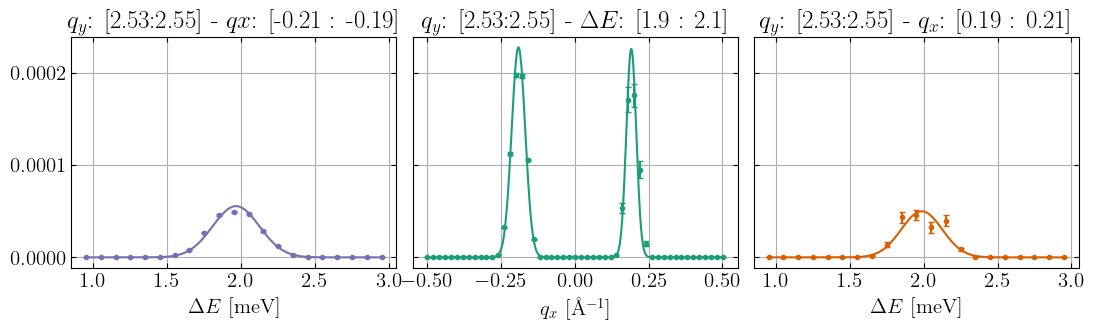

In [17]:
qx_range = np.linspace(min(qx_c1), max(qx_c1), 1000)
E_range = np.linspace(min(qx_c2), max(qx_c2), 1000)

fig, ax = plt.subplots(1,3, figsize=(13,3), sharey=True)
fig.subplots_adjust(wspace=0.05)

ax[0].errorbar(qx_c3, c3.values, np.sqrt(c3.variances), fmt='.', label='Data', color='#7570b3')
ax[0].plot(E_range, gaussN(E_range, *Ecut_fit3.values), color='#7570b3')
ax[0].set_title(r'$q_y$: [2.53:2.55] - $qx$: [-0.21 : -0.19]')
ax[0].set_xlabel(r'$\Delta E$ [meV]')
ax[0].grid()

ax[1].errorbar(qx_c1, c1.values, np.sqrt(c1.variances), fmt='.', label='Data', color='#1b9e77')
ax[1].plot(qx_range, gaussN(qx_range, *Ecut_fit1.values), color='#1b9e77')
ax[1].set_title(r'$q_y$: [2.53:2.55] - $\Delta E$: [1.9 : 2.1]')
ax[1].set_xlabel(r'$q_x$ [Å$^{-1}$]')
ax[1].grid()
#
ax[2].errorbar(qx_c2, c2.values, np.sqrt(c2.variances), fmt='.', label='Data', color='#d95f02')
ax[2].plot(E_range, gaussN(E_range, *Ecut_fit2.values), color='#d95f02')
ax[2].set_title(r'$q_y$: [2.53:2.55] - $q_x$: [0.19 : 0.21]')
ax[2].set_xlabel(r'$\Delta E$ [meV]')
ax[2].grid()
plt.savefig('qx_cuts.pdf', format='pdf', bbox_inches='tight')


# Sliced along $q_y$

In [18]:

qy_min = -1 * sc.Unit('Å^(-1)')
qy_max = 2 * sc.Unit('Å^(-1)')

E_min = -0.05 * sc.Unit('meV')
E_max = 7.0 * sc.Unit('meV')


def update_plot_qyE(amp):
    qx_layer = amp * sc.Unit('Å^(-1)')
    plt.figure(figsize=(6,4))
    p1 = sliced_qxE['qx', qx_layer]['deltaE', E_min:E_max].transpose()#.plot(cmap='jet')
    im = plt.pcolormesh(p1.coords['qy'].values, p1.coords['deltaE'].values, p1.values, cmap='jet', vmin=0, vmax=0.0001)
    cbar = plt.colorbar(im)
    cbar.set_label('I [a.u.]')
    plt.xlim(1.5,4)
    plt.ylim(0,7)
    plt.xlabel('$q_y$ [1/Å]')
    plt.ylabel('$\Delta E$ [meV]')
    plt.title(f"$q_x =$ {amp:.2f} Å$^{-1}$")
    plt.savefig('Pb_phonon_BIFROST_qyE_low.pdf', format='pdf', bbox_inches='tight')
    

w_qyE = ipw.FloatSlider( 
    value=0.17,
    min=min(sliced_qxE.coords['qx'].values),
    max=4,
    step=(sliced_qxE.coords['qx'].values[1]-sliced_qxE.coords['qx'].values[0]),
    description="q_x:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
)
# Display the slider


ipw.interactive(update_plot_qyE, amp=w_qyE)

interactive(children=(FloatSlider(value=0.17, description='q_x:', max=4.0, min=-1.951717, step=0.0200233223443…

## Cuts integrating $q_y$ 

In [19]:
c4_qx= 0 * sc.Unit('Å^(-1)')

c4_Emin = 1.8 * sc.Unit('meV')
c4_Emax = 2.2 * sc.Unit('meV')

c4_qymin = 2 * sc.Unit('Å^(-1)')
c4_qymax = 3 * sc.Unit('Å^(-1)')


c4 = sliced_qxE['qx', c4_qx]['qy',c4_qymin:c4_qymax]['deltaE', c4_Emin:c4_Emax]
c4 = sc.sum(c4, dim='deltaE')

qy_c4 = c4.coords['qy'].values
qy_c4 = (qy_c4[:-1] + qy_c4[1:]) / 2.0

E_c4_guess = {'A1':0.0002, 'mu1':2.33, 'sigma1': 0.01,
                 'A2': 0.0002, 'mu2':2.73, 'sigma2': 0.01,}
E_c4_limit = {'A2': (0.0001,0.0004)}

Ecut_fit4 = fit(qy_c4, c4.values, np.sqrt(c4.variances), gaussN, E_c4_guess, limits=E_c4_limit)

Ecut_fit4.hesse()

Given names not corresponding to function, overwriting...


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1103                       │              Nfcn = 495              │
│ EDM = 8.46e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  169e-6   │   9e-6    │            │            │         │         │       │
│ 1 │ mu1    │  2.3461   │  0.0007   │            │            │         │         │       │
│ 2 │ sigma1 │  19.4e-3  │  0.5e-3   │            │            │         │         │       │
│ 3 │ A2     │ 301.2e-6  │  2.0e-6   │            │            │ 0.0001  │ 0.0004  │       │
│ 4 │ mu2    │  2.73013  │  0.00011  │            │            │         │         │       │
│ 5 │ sigma2 │ 18.84e-3  │  0.05e-3  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────┐
│        │        A1       mu1    sigma1        A2       mu2    sigma2 │
├────────┼─────────────────────────────────────────────────────────────┤
│     A1 │  8.87e-11  1.79e-09 -3.07e-09 -9.79e-19 -1.74e-17  1.82e-17 │
│    mu1 │  1.79e-09  4.73e-07 -4.37e-08 -4.03e-17 -8.17e-16  9.48e-16 │
│ sigma1 │ -3.07e-09 -4.37e-08  2.42e-07  4.53e-17  8.61e-16 -9.53e-16 │
│     A2 │ -9.79e-19 -4.03e-17  4.53e-17  3.84e-12 -5.76e-14 -4.15e-11 │
│    mu2 │ -1.74e-17 -8.17e-16  8.61e-16 -5.76e-14  1.29e-08 -1.71e-09 │
│ sigma2 │  1.82e-17  9.48e-16 -9.53e-16 -4.15e-11 -1.71e-09  2.67e-09 │
└────────┴─────────────────────────────────────────────────────────────┘

In [20]:
qx_layer = 0 * sc.Unit('Å^(-1)')

c5_qymin = 2.33 * sc.Unit('Å^(-1)')
#c5_qymax = 2.36 * sc.Unit('Å^(-1)')

c5_Emin = 1 * sc.Unit('meV')
c5_Emax = 3 * sc.Unit('meV')

c5 = sliced_qxE['qx', qx_layer]['qy',c5_qymin]['deltaE', c5_Emin:c5_Emax]
#c5 = sc.sum(c5, dim='qy')

qy_c5 = c5.coords['deltaE'].values
qy_c5 = (qy_c5[:-1] + qy_c5[1:]) / 2.0

E_c5_guess = {'A1':0.00005, 'mu1':2, 'sigma1': 0.2,}
E_c5_limit = {'A1': (0.00001,0.0003), 'mu1':(1,3)}

Ecut_fit5 = fit(qy_c5, c5.values, np.sqrt(c5.variances), gaussN, E_c5_guess, limits=E_c5_limit)

Ecut_fit5.hesse()


Given names not corresponding to function, overwriting...


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 44.51                      │              Nfcn = 207              │
│ EDM = 3.38e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   53e-6   │   4e-6    │            │            │  1e-05  │ 0.0003  │       │
│ 1 │ mu1    │   1.994   │   0.008   │            │            │    1    │    3    │       │
│ 2 │ sigma1 │  0.1195   │  0.0031   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────┐
│        │        A1       mu1    sigma1 │
├────────┼───────────────────────────────┤
│     A1 │  1.39e-11 -1.16e-08 -6.71e-09 │
│    mu1 │ -1.16e-08  6.02e-05  1.71e-05 │
│ sigma1 │ -6.71e-09  1.71e-05   9.8e-06 │
└────────┴───────────────────────────────┘

In [21]:
c6_qymin = 2.73 * sc.Unit('Å^(-1)')
#c6_qymax = 2.76 * sc.Unit('Å^(-1)')

c6_Emin = 1 * sc.Unit('meV')
c6_Emax = 3 * sc.Unit('meV')

c6 = sliced_qxE['qx', qx_layer]['qy',c6_qymin]['deltaE', c6_Emin:c6_Emax]
#c6 = sc.sum(c6, dim='qy')

qy_c6 = c6.coords['deltaE'].values
qy_c6 = (qy_c6[:-1] + qy_c6[1:]) / 2.0

E_c6_guess = {'A1':0.00005, 'mu1':2, 'sigma1': 0.2,}
E_c6_limit = {'A1': (0.00001,0.0003), 'mu1':(1,3)}

Ecut_fit6 = fit(qy_c6, c6.values, np.sqrt(c6.variances), gaussN, E_c6_guess, limits=E_c6_limit)

Ecut_fit6.hesse()

c5


Given names not corresponding to function, overwriting...


<scipp.DataArray>
Dimensions: Sizes[deltaE:21, ]
Coordinates:
* deltaE                    float64            [meV]  (deltaE [bin-edge])  [0.900123, 1.00012, ..., 2.90003, 3.00003]
  qx                        float64           [1/Å]  (qx [bin-edge])  [-0.00945473, 0.0105686]
  qy                        float64           [1/Å]  (qy [bin-edge])  [2.32876, 2.34875]
Data:
                            float64      [arb. unit]  (deltaE)  [0, 0, ..., 0, 0]  [0, 0, ..., 0, 0]

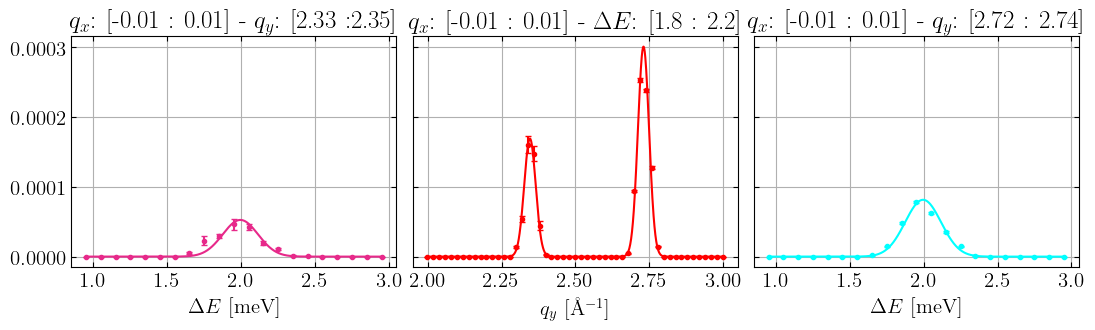

In [22]:
q_range2 = np.linspace(min(qy_c4), max(qy_c4),1000)
E_range2 = np.linspace(min(qy_c6), max(qy_c6),1000)

fig, ax = plt.subplots(1,3, figsize=(13,3), sharey=True)
fig.subplots_adjust(wspace=0.05)

ax[0].errorbar(qy_c5, c5.values, np.sqrt(c5.variances), fmt='.', label='Data', color='#e7298a')
ax[0].plot(E_range2, gaussN(E_range2, *Ecut_fit5.values), color='#e7298a')
ax[0].set_title(r'$q_x$: [-0.01 : 0.01] - $q_y$: [2.33 :2.35]')
ax[0].set_xlabel(r'$\Delta E$ [meV]')
ax[0].grid()

ax[1].errorbar(qy_c4, c4.values, np.sqrt(c4.variances), fmt='.', label='Data', color='red')
ax[1].plot(q_range2, gaussN(q_range2, *Ecut_fit4.values), color='red')
ax[1].set_title(r'$q_x$: [-0.01 : 0.01] - $\Delta E$: [1.8 : 2.2]')
ax[1].set_xlabel(r'$q_y$ [Å$^{-1}$]')
ax[1].grid()

ax[2].errorbar(qy_c6, c6.values, np.sqrt(c6.variances), fmt='.', label='Data', color='cyan')
ax[2].plot(E_range2, gaussN(E_range2, *Ecut_fit6.values), color='cyan')
ax[2].set_title(r'$q_x$: [-0.01 : 0.01] - $q_y$: [2.72 : 2.74]')
ax[2].set_xlabel(r'$\Delta E$ [meV]')
ax[2].grid()

plt.savefig('qy_cuts.pdf', format='pdf', bbox_inches='tight')

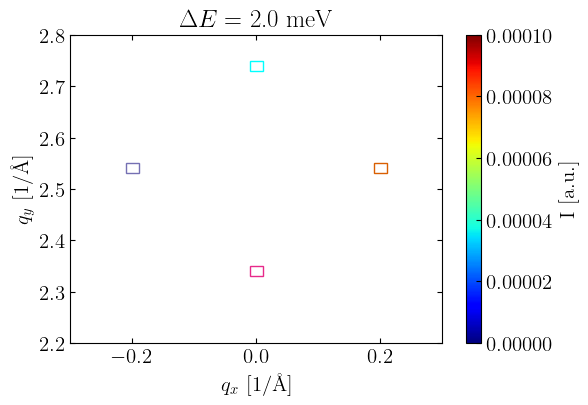

In [23]:
from matplotlib.patches import Polygon

E_layer = 2.0 * sc.Unit('meV')
fig, ax = plt.subplots(1,1,figsize=(6,4))
p1 = sliced['deltaE', E_layer]['qy', qy_min:qy_max].transpose()#.plot(cmap='jet')
im = ax.pcolormesh(p1.coords['qx'].values, p1.coords['qy'].values, p1.values, cmap='jet',  vmin=0, vmax=0.0001) # vmin=0, vmax=3e-5
cbar = plt.colorbar(im)
cbar.set_label('I [a.u.]')
ax.set_xlim(-0.3,0.3)
ax.set_ylim(2.2,2.8)
ax.set_xlabel('$q_x$ [1/Å]')
ax.set_ylabel('$q_y$ [1/Å]')
ax.set_title(f"$\Delta E =$ 2.0 meV")
vertices2 = [(-0.01, 2.33), (0.01, 2.33), (0.01, 2.35),(-0.01, 2.35)]
parallelogram2 = Polygon(vertices2, closed=True, edgecolor='#e7298a', facecolor='none')
ax.add_patch(parallelogram2)

vertices3 = [(-0.01, 2.73), (0.01, 2.73), (0.01, 2.75),(-0.01, 2.75)]
parallelogram3 = Polygon(vertices3, closed=True, edgecolor='cyan', facecolor='none')
ax.add_patch(parallelogram3)

vertices4 = [(-0.21, 2.53), (-0.19, 2.53), (-0.19, 2.55),(-0.21, 2.55)]
parallelogram4 = Polygon(vertices4, closed=True, edgecolor='#7570b3', facecolor='none')
ax.add_patch(parallelogram4)

vertices5 = [(0.21, 2.53), (0.19, 2.53), (0.19, 2.55),(0.21, 2.55)]
parallelogram5 = Polygon(vertices5, closed=True, edgecolor='#d95f02', facecolor='none')
ax.add_patch(parallelogram5)

plt.savefig('Pb_phonon_BIFROST_qxqy_low.pdf', format='pdf', bbox_inches='tight')

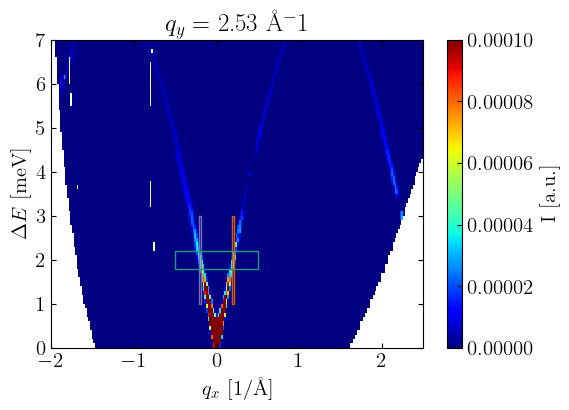

In [24]:
qy_layer = 2.53 * sc.Unit('Å^(-1)')
fig, ax = plt.subplots(1,1,figsize=(6,4))
p1 = sliced_qxE['qy', qy_layer]['deltaE', E_min:E_max].transpose()#.plot(cmap='jet')
im = ax.pcolormesh(p1.coords['qx'].values, p1.coords['deltaE'].values, p1.values, cmap='jet', vmin=0, vmax=0.0001) # norm=colors.LogNorm()
cbar = plt.colorbar(im)
cbar.set_label('I [a.u.]')
ax.set_xlim(-2,2.5)
ax.set_ylim(0,7)
ax.set_xlabel('$q_x$ [1/Å]')
ax.set_ylabel('$\Delta E$ [meV]')
ax.set_title(f"$q_y =$ 2.53 Å$^{-1}$")

vertices5 = [(-0.21, 1), (-0.19, 1), (-0.19, 3),(-0.21, 3)]
parallelogram5 = Polygon(vertices5, closed=True, edgecolor='#7570b3', facecolor='none')
ax.add_patch(parallelogram5)

vertices6 = [(0.21, 1), (0.19, 1), (0.19, 3),(0.21, 3)]
parallelogram6 = Polygon(vertices6, closed=True, edgecolor='#d95f02', facecolor='none')
ax.add_patch(parallelogram6)

vertices6 = [(0.5, 1.8), (-0.5, 1.8), (-0.5, 2.2),(0.5, 2.2)]
parallelogram6 = Polygon(vertices6, closed=True, edgecolor='#1b9e77', facecolor='none')
ax.add_patch(parallelogram6)

plt.savefig('Pb_phonon_BIFROST_qxE_mid.pdf', format='pdf', bbox_inches='tight')

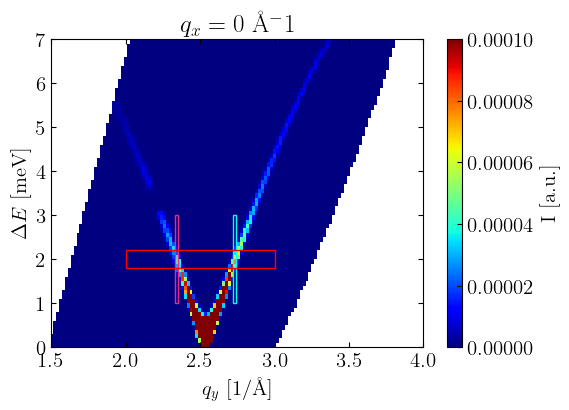

In [25]:
qx_layer = 0 * sc.Unit('Å^(-1)')
fig, ax = plt.subplots(1,1,figsize=(6,4))
p1 = sliced_qxE['qx', qx_layer]['deltaE', E_min:E_max].transpose()#.plot(cmap='jet')
im = ax.pcolormesh(p1.coords['qy'].values, p1.coords['deltaE'].values, p1.values, cmap='jet', vmin=0, vmax=0.0001)
cbar = plt.colorbar(im)
cbar.set_label('I [a.u.]')
ax.set_xlim(1.5,4)
ax.set_ylim(0,7)
ax.set_xlabel('$q_y$ [1/Å]')
ax.set_ylabel('$\Delta E$ [meV]')
ax.set_title(f"$q_x =$ 0 Å$^{-1}$")

vertices5 = [(2.33, 1), (2.35, 1), (2.35, 3),(2.33, 3)]
parallelogram5 = Polygon(vertices5, closed=True, edgecolor='#e7298a', facecolor='none')
ax.add_patch(parallelogram5)

vertices6 = [(2.72, 1), (2.74, 1), (2.74, 3),(2.72, 3)]
parallelogram6 = Polygon(vertices6, closed=True, edgecolor='cyan', facecolor='none')
ax.add_patch(parallelogram6)

vertices6 = [(3, 1.8), (2, 1.8), (2, 2.2),(3, 2.2)]
parallelogram6 = Polygon(vertices6, closed=True, edgecolor='red', facecolor='none')
ax.add_patch(parallelogram6)

plt.savefig('Pb_phonon_BIFROST_qyE_mid.pdf', format='pdf', bbox_inches='tight')

# Fitting phonon in (h,k)

In [26]:
def to_h(qx):
    return qx / (2 * np.pi)

def to_k(qy):
    return qy / (2 * np.pi)

graph = {'h': to_h}
graph2 = {'k': to_k}

transformed = sliced.transform_coords(['h'], graph=graph)
transformed2 = transformed.transform_coords(['k'], graph=graph2)

## Making slices

In [27]:
p1 = sliced_qxE['qy', qy_layer]['deltaE', E_min:E_max].transpose()
p1

<scipp.DataArray>
Dimensions: Sizes[deltaE:71, qx:273, ]
Coordinates:
* deltaE                    float64            [meV]  (deltaE [bin-edge])  [-0.0998327, 0.000162933, ..., 6.89986, 6.99985]
* qx                        float64           [1/Å]  (qx [bin-edge])  [-1.95172, -1.93169, ..., 3.49463, 3.51465]
  qy                        float64           [1/Å]  (qy [bin-edge])  [2.52864, 2.54862]
Data:
                            float64      [arb. unit]  (deltaE, qx)  [nan, nan, ..., nan, nan]  [nan, nan, ..., nan, nan]